In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import logging
import scipy.stats as sts
import pickle
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import os

from arch import arch_model

In [2]:
ini_work_dir = os.getcwd()
# os.chdir('..')

In [3]:
from rules_related import combine_rules_outputs
from whole_algorithm import train_model
from auxiliary import calc_log_returns, unpack_1d_parameters
from multivariate_normal_distribution import LongMultivariateNormal
from model import FuzzyVolatilityModel
from antecedent_fitting import fit_antecedent_params
from local_models import calculate_retraining_garch_forecasts

In [4]:
with open('config.json') as file:
    config = json.load(file)

In [5]:
files_folder = config['files_folders']['processed']
research_results_folder = config['files_folders']['research_results']
antecedent_params_folder = config['files_folders']['antecedent_params_sets']
logs_folder = config['files_folders']['logs']

In [6]:
NB_NO = 0

METADATA_FILE_NAME = 'current_antecedent_fitting_metadata_seasonal.pkl'
SUMMARY_TABLE_NAME = 'summary_table_seasonal'

RESULT_RAW_FILE_NAME = f'fitting_consequent_params_seasonal_raw_result_nb_{NB_NO}'
RESULT_BIG_FILE_NAME = f'fitting_consequent_params_seasonal_result_nb_{NB_NO}'

In [7]:
logger = logging.getLogger(f'apf_seas_nb_{NB_NO}')  # apf == antecedent params fitting

_log_file = f'{logs_folder}/{logger.name}.log'
logging.basicConfig(level=logging.INFO,
                    filename=_log_file,
                    filemode='w',
                    format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
                    datefmt='%H:%M:%S')

In [8]:
pd.options.display.precision = 15
pd.options.display.max_colwidth = 300

# Reading data

In [9]:
with open(f'{antecedent_params_folder}/{METADATA_FILE_NAME}', 'rb') as file:
    data = pickle.load(file)

In [10]:
train = data['train']
test = data['test']
consequent_metaparams = data['consequent_metaparams']
consequent_params_ini = data['consequent_metaparams']['parameters_ini']
antecedent_params_set = data['antecedent_params_set']
clusterization_method = data['clusterization_method']
local_method = data['local_method']
data_to_cluster_train = data['data_to_cluster_train']
data_to_cluster_test = data['data_to_cluster_test']
cluster_sets_conjunction = data['cluster_sets_conjunction']
n_last_points_to_use_for_clustering = data['n_last_points_to_use_for_clustering']
other_fvm_parameters = data['other_fvm_parameters']

In [11]:
n_cluster_sets = len(data['clusterization_method'])

p = consequent_metaparams['p']
q = consequent_metaparams['q']

n_train = train.shape[0]
n_test = test.shape[0]

# Main input data plot

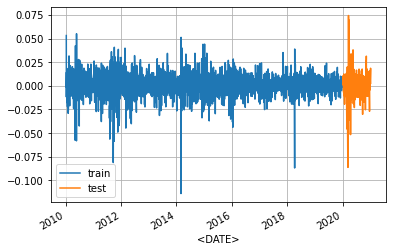

In [12]:
train.plot(label='train')
test.plot(label='test')

plt.legend()
plt.grid()
plt.show()

## train & test sizes

In [13]:
print(train.shape[0], test.shape[0])

2511 252


# Antecedent params set

In [14]:
len(antecedent_params_set)

2592

In [15]:
_ / 2

1296.0

In [16]:
# antecedent_params_set = antecedent_params_set[0:1296]

In [17]:
len(antecedent_params_set)

2592

In [18]:
# for _antecedent_params in antecedent_params_set:
#     _centers = _antecedent_params['centers']
#     _variances = _antecedent_params['variances']
#     _n_clusters = _antecedent_params['n_clusters']
    
#     for i in range(_n_clusters):
#         _range = np.arange(-20, 20, .01)
#         _data = sts.norm(_centers[i], _variances[i] ** .5).pdf(_range)

#         plt.plot(_range, _data, label=f'cluster #{i + 1}')
    
#     plt.title(_antecedent_params)
#     plt.legend()
#     plt.grid()
#     plt.show()

# Algorithm parameters

In [19]:
use_multiprocessing = True
do_feeding = False

# Fitting

In [20]:
result = None

In [ ]:
%%time

result = fit_antecedent_params(train,
                               test,
                               consequent_metaparams=consequent_metaparams,
                               consequent_params_ini=consequent_params_ini,
                               antecedent_params_set=antecedent_params_set,
                               clusterization_method=clusterization_method,
                               local_method=local_method,
                               data_to_cluster_train=data_to_cluster_train,
                               data_to_cluster_test=data_to_cluster_test,
                               cluster_sets_conjunction=cluster_sets_conjunction,
                               n_last_points_to_use_for_clustering=n_last_points_to_use_for_clustering,
                               n_cluster_sets=n_cluster_sets,
                               other_fvm_parameters=other_fvm_parameters,
                               use_multiprocessing=use_multiprocessing,
                               do_feeding=do_feeding)

In [ ]:
_cur_time = str(pd.Timestamp.today()).replace(':', '-')
print(_cur_time)

with open(f'{research_results_folder}/{RESULT_RAW_FILE_NAME}_{_cur_time}', 'wb') as file:
    pickle.dump(result, file)

In [ ]:
res_df = pd.DataFrame.from_records(result).copy()

In [ ]:
if (res_df['status'] != 0).any():
    _text = 'Not all models were fitted'
    logger.warning(_text)
    print(_text)

In [ ]:
fitted_antecedent_params = res_df[res_df['rmse'] == res_df['rmse'].min()].iloc[0]['antecedent_params']

# Adding some info

In [ ]:
result_big = {'result': result, 'fitted': fitted_antecedent_params}

result_big['train'] = train
result_big['test'] = test
result_big['antecedent_params_set'] = antecedent_params_set
result_big['consequent_metaparams'] = consequent_metaparams
result_big['consequent_params_ini'] = consequent_params_ini
result_big['clusterization_method'] = clusterization_method
result_big['local_method'] = local_method
result_big['data_to_cluster_train'] = data_to_cluster_train
result_big['data_to_cluster_test'] = data_to_cluster_test

In [ ]:
_cur_time = str(pd.Timestamp.today()).replace(':', '-')
print(_cur_time)

with open(f'{research_results_folder}/{RESULT_BIG_FILE_NAME}_{_cur_time}.pkl', 'wb') as file:
    pickle.dump(result_big, file)

## Vanilla GARCH errors

### No retraining

In [25]:
garch_mean = 'Zero'
garch_dist = 'normal'
garch_vol = 'GARCH'

garch = arch_model(train,
                   mean=garch_mean,
                   vol=garch_vol,
                   p=p,
                   q=q,
                   dist=garch_dist)
garch_fitted = garch.fit()

/home/vsviyazov/.conda/envs/fuzzy-volatility/lib/python3.9/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0004635. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      5,   Neg. LLF: 3346.999921874939
Iteration:      2,   Func. Count:     12,   Neg. LLF: -137.29482889613666
Iteration:      3,   Func. Count:     20,   Neg. LLF: -242.51818601755076
Iteration:      4,   Func. Count:     25,   Neg. LLF: -242.23976520922335
Iteration:      5,   Func. Count:     30,   Neg. LLF: -243.05880468755805
Iteration:      6,   Func. Count:     35,   Neg. LLF: -183.15921543727583
Iteration:      7,   Func. Count:     41,   Neg. LLF: -243.26705878028932
Iteration:      8,   Func. Count:     45,   Neg. LLF: -243.28708365177656
Iteration:      9,   Func. Count:     49,   Neg. LLF: -243.2920997265208
Iteration:     10,   Func. Count:     53,   Neg. LLF: -243.29219809018068
Iteration:     11,   Func. Count:     57,   Neg. LLF: -243.29222039669366
Iteration:     12,   Func. Count:     60,   Neg. LLF: -243.292220396315
Optimization terminated successfully    (Exit mode 0)
            Current function value: -243.29222039669366
       

In [26]:
simple_garch_forecasts = garch_fitted.forecast(horizon=n_test, reindex=False).variance.iloc[0].values

In [27]:
mse = mean_squared_error(simple_garch_forecasts, test ** 2, squared=True)
rmse = mean_squared_error(simple_garch_forecasts, test ** 2, squared=False)
mape = mean_absolute_percentage_error(simple_garch_forecasts, test ** 2)

garch_errors = {'mse': mse, 'rmse': rmse, 'mape': mape}
garch_errors

{'mse': 1.7906256858366067e-07,
 'rmse': 0.00042315785303319217,
 'mape': 0.7622637871846474}

In [18]:
result['Vanilla GARCH n/r errors'] = garch_errors

NameError: name 'result' is not defined

### W/ retraining

In [19]:
retraining_garch_forecasts = calculate_retraining_garch_forecasts(train, test,
                                                                  mean=garch_mean,
                                                                  vol=garch_vol,
                                                                  p=p,
                                                                  q=q,
                                                                  dist=garch_dist)

/home/vsviyazov/.conda/envs/fuzzy-volatility/lib/python3.9/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002796. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/home/vsviyazov/.conda/envs/fuzzy-volatility/lib/python3.9/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002785. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/home/vsviyazov/

Iteration:      1,   Func. Count:      5,   Neg. LLF: 7334798.255945578
Iteration:      2,   Func. Count:     11,   Neg. LLF: -697.6209943392456
Optimization terminated successfully    (Exit mode 0)
            Current function value: -697.6209943317531
            Iterations: 6
            Function evaluations: 11
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      5,   Neg. LLF: 6730712.147932139
Iteration:      2,   Func. Count:     12,   Neg. LLF: 66.6608821584719
Iteration:      3,   Func. Count:     21,   Neg. LLF: -651.1042057815349
Iteration:      4,   Func. Count:     28,   Neg. LLF: -661.7847301614318
Iteration:      5,   Func. Count:     33,   Neg. LLF: -693.5699182766039
Iteration:      6,   Func. Count:     38,   Neg. LLF: -702.1688891135552
Iteration:      7,   Func. Count:     43,   Neg. LLF: -702.2421777037339
Iteration:      8,   Func. Count:     48,   Neg. LLF: -702.2437165113522
Optimization terminated successfully    (Exit mode 0)
            

/home/vsviyazov/.conda/envs/fuzzy-volatility/lib/python3.9/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002726. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/home/vsviyazov/.conda/envs/fuzzy-volatility/lib/python3.9/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002716. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/home/vsviyazov/

In [20]:
_mse = mean_squared_error(retraining_garch_forecasts, test ** 2, squared=True)
_rmse = mean_squared_error(retraining_garch_forecasts, test ** 2, squared=False)
_mape = mean_absolute_percentage_error(retraining_garch_forecasts, test ** 2)

retr_garch_errors = {'mse': _mse, 'rmse': _rmse, 'mape': _mape}
retr_garch_errors

{'mse': 2.2999998015909406e-08,
 'rmse': 0.00015165750233967789,
 'mape': 0.8044550481851159}

In [ ]:
result['Vanilla GARCH w/r errors'] = retr_garch_errors

# Dumping

## into a single file

In [ ]:
cur_time = str(pd.Timestamp.today().floor('s')).replace(':', '-')
print(cur_time)

with open(f'{research_results_folder}/fitting_consequent_params_seasonal_result_{cur_time}.pkl', 'wb') as file:
    pickle.dump(result, file)

## into a table

In [ ]:
# summary = pd.DataFrame(columns=['Time',
#                                 'p', 'q',
#                                 'Start date', 'Train size', 'Test size',
#                                 '# clusters', 'Centers', 'Variances',
#                                 'MSE', 'Vanilla GARCH MSE (no retraining)', 'Vanilla GARCH MSE (w/ retraining)'])

In [ ]:
summary_pkl_loc = f'{research_results_folder}/{summary_table_name}.pkl'

summary = pd.read_pickle(summary_pkl_loc)

new_entries = []

_garch_nr_mse = result['Vanilla GARCH n/r errors']['mse']
_garch_wr_mse = result['Vanilla GARCH w/r errors']['mse']

for i in range(len(result['fvms'])):
    _antecedent_params = result['antecedent_params_set'][i]
    _centers = _antecedent_params['centers']
    _vars = _antecedent_params['variances']
    _n_clusters = _antecedent_params['n_clusters']
    
    _mse = result['mses'][i]
    
    new_entry = {
        'Time': cur_time,
        'p': p,
        'q': q,
        'Start date': train.index.min(),
        'Train size': n_train,
        'Test size': n_test,
        '# clusters': _n_clusters,
        'Centers': _centers,
        'Variances': _vars,
        'MSE': _mse,
        'Vanilla GARCH MSE (no retraining)': _garch_nr_mse,
        'Vanilla GARCH MSE (w/ retraining)': _garch_wr_mse
    }
    
    new_entries.append(new_entry)

summary = summary.append(new_entries, ignore_index=True, verify_integrity=False, sort=False).copy()

summary.to_pickle(f'{research_results_folder}/{summary_table_name}.pkl')
summary.to_excel(f'{research_results_folder}/{summary_table_name}.xlsx')

In [ ]:
# _ini = pd.read_excel(f'files/summary_table_ini_2022-02-05.xlsx')

# Looking at results

In [ ]:
fvms = result['fvms']

In [ ]:
result['mses']

In [ ]:
plt.plot(fvms[0].h[:-1], label='forecast')
plt.plot(input_cut.values ** 2, label='actual values')

plt.legend()
plt.grid()
plt.show()

In [ ]:
(fvms[0].hist_output ** .5).plot(label='forecast', figsize=(15, 8))
pd.Series(simple_garch_forecasts ** .5, index=fvms[0].hist_output.index).plot(label='vanilla GARCH(1, 1) (no retraining)')
input_cut.plot(label='actual values')

plt.legend()
plt.grid()
plt.show()

In [ ]:
fvms[0].hist_output.plot(label='forecast', figsize=(15, 8))
pd.Series(simple_garch_forecasts, index=fvms[0].hist_output.index).plot(label='vanilla GARCH(1, 1) (no retraining)')
(input_cut ** 2).plot(label='actual values')

plt.legend()
plt.grid()
plt.show()